In [1]:
# # ML Trader
import numpy as np
import pandas as pd

import collections

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display

import datetime as dt

import winsound

import warnings
warnings.filterwarnings('ignore')

In [2]:
def before_sema(data):   
    data['sema_list'].append(data['tick'])    
    return(data)

def after_sema(data):     
    data['sema_list'].popleft()
    data['sema_list'].append(data['tick'])
    data['sema'] = list(pd.DataFrame(list(data['sema_list'])).ewm(span=data['sema_len']).mean()[0])[-1]
    return(data)

def before_lema(data):   
    data['lema_list'].append(data['tick'])    
    return(data)

def after_lema(data):     
    data['lema_list'].popleft()
    data['lema_list'].append(data['tick'])
    data['lema'] = list(pd.DataFrame(list(data['lema_list'])).ewm(span=data['lema_len']).mean()[0])[-1]
    return(data)

In [3]:
def print_report(data):
    display.clear_output(wait = True)
    print('--------------------------')
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-----------')
    print(data['pl_list'])
    print('--------------------------')
    return()

In [4]:
def read_data(data):
    source_file_path = f'..\\data\\yearly_tick_data\\{data["year"]}.csv'

    if data['input_rows'] is None:
        data["df"] = pd.read_csv(source_file_path)
    else:
        data["df"] = pd.read_csv(source_file_path, nrows=data['input_rows'])
        
    data["df"] = data["df"][data["df"]['DateTime'].str.contains('|'.join(data['date_list']))]
#     data["df"] = data["df"][data["df"]['DateTime'].str.contains(data['date_val'])]
    
    data["df"]['tick'] = np.float()
    data["df"]['sema'] = np.float()
    data["df"]['lema'] = np.float()
    
    return(data["df"])

def get_dir(data):
    if not data['open_order']:
        if data['sema'] > data['lema']:
            data['position'] = 1

        elif data['sema'] < data['lema']:
            data['position'] = -1
    
    if data['open_order']:        
        if data['tick'] > data['lema']:
            data['position'] = 1

        elif data['tick'] < data['lema']:
            data['position'] = -1
    
    return(data)

In [5]:
def get_dir(data):
    
    if data['sema'] > data['lema']:
        data['position'] = 1

    elif data['sema'] < data['lema']:
        data['position'] = -1
    
    return(data)

In [6]:
def after_dir(data):   
    
    data['dir_list'].popleft()
    data['dir_list'].append(data['position'])   
    
    if sum(data['dir_list']) != 0:
        data['dir_change'] = False

    elif sum(data['dir_list']) == 0:
        data['dir_change'] = True
        #print(data['dir_list'])

    return(data)

In [7]:
def make_order(data):
    if not data['open_order']:
        if data['dir_change']:
            if data['position'] > 0:
                data['order_ask_price'] = data['ask']
                data['open_order'] = True
                data['open_order_type'] = 'long'
                
            elif data['position'] < 0:
                data['order_bid_price'] = data['bid']
                data['open_order'] = True
                data['open_order_type'] = 'short'
    return(data)

In [8]:
def close_order(data):
    if data['open_order']:
        if data['dir_change']:
            if data['position'] < 0:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                              
                
            elif data['position'] > 0:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
    return(data)

In [9]:
def tick_close(data):
    if data['open_order']:
        if data['open_order_type'] == 'short':
            if data['tick'] - data['lema'] >= 0:
                data['close_ask_price'] = data['ask']
                data['pl'] = np.round(data['order_bid_price'] - data['close_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
                
        if data['open_order_type'] == 'long':
            if data['lema'] - data['tick'] >= 0:
                data['close_bid_price'] = data['bid']
                data['pl'] = np.round(data['close_bid_price'] - data['order_ask_price'], 4)
                data['pl_list'].append(data['pl'])
                data['dt_list'].append(data['dt_val'])
                data['open_order'] = False
    return(data)

In [10]:
def get_date_list(data):
    
    data['start_date'] = dt.datetime(year=data['start_date']['year'],
                      month=data['start_date']['month'],
                      day=data['start_date']['date'])

    data['end_date'] = dt.datetime(year=data['end_date']['year'],
                      month=data['end_date']['month'],
                      day=data['end_date']['date'])

    
    date_list = list(pd.date_range(data['start_date'],data['end_date'],freq='d').values)
    data['date_list'] = [str(x).split('T')[0].replace('-','') for x in date_list]
    return(data)

In [11]:
def get_run_duration(data):
    run_time = len(data["date_list"]) * 6
    hours = run_time//60
    mins = run_time%60
    print(f'Approx run time : {hours}-hours : {mins}-mins')

In [12]:
def split_date_col(data):
    data['total_df']['year_val'] = [x.year for x in data['total_df']['date']]
    data['total_df']['month_val'] = [x.month for x in data['total_df']['date']]
    data['total_df']['date_val'] = [x.day for x in data['total_df']['date']]
    data['total_df']['hour_val'] = [x.hour for x in data['total_df']['date']]
    data['total_df']['minute_val'] = [x.minute for x in data['total_df']['date']]

In [13]:
def plot_graph(data):
    
    figure(num=None, figsize=(50, 10), dpi=80, facecolor='w', edgecolor='k')

    data["df"]['tick'].plot(label = 'tick')
    data["df"]['sema'].plot(label = 'sema')
    data["df"]['lema'].plot(label = 'lema')
    plt.legend(loc="upper left")

In [14]:
def print_report(data):
    pl_list = list(data['pl_list'])
    net_pl = round(np.sum(pl_list),5)

    positive_pls = [i for i in pl_list if i > 0]
    negative_pls = [i for i in pl_list if i < 0]

    num_positive = len(positive_pls)
    num_negative = len(negative_pls)

    sum_positive = round(np.sum(positive_pls),5)
    sum_negative = round(np.sum(negative_pls),5)
    sum_total    = round(sum_positive + abs(sum_negative),5) 

    avg_positive = round(np.mean(positive_pls),5)
    avg_negative = round(np.mean(negative_pls),5)

    
    print('==============================')
    print(f'date_val          : {data["date_list"]}')    
    print(f'Total PL : {sum(data["pl_list"])}')
    print('-------------')
    print(f'net_pl            : {net_pl}/{sum_total}')  
    print('-------------')
    print(f'+ve               : num= {num_positive}    sum= +{sum_positive}    avg= +{avg_positive}')
    print(f'-ve               : num= {num_negative}    sum= {sum_negative}    avg= {avg_negative}')
    print('==============================')

In [15]:
def run_engine(data):
    for i in tqdm(range(0, len(data["df"]))):
        data['ask'] = data["df"]['Ask'][i]
        data['bid'] = data["df"]['Bid'][i]
        data['tick'] = (data['ask'] + data['bid'])/2    
        data["df"]['tick'][i] = data['tick']
        #data['dt_val'] = data["df"]['DateTime'][i]        
        data['dt_val'] = dt.datetime.strptime(data["df"]['DateTime'][i].split(".")[0],"%Y%m%d %H:%M:%S")

        # sema before after loops --------------------------------
        if len(data['sema_list']) < data['sema_len']:
            data =  before_sema(data)
            continue

        if len(data['sema_list']) == data['sema_len']:
            data = after_sema(data)     
        # ----------------------------------------------------------


        # lema before after loops --------------------------------
        if len(data['lema_list']) < data['lema_len']:
            data = before_lema(data)        
            continue

        if len(data['lema_list']) == data['lema_len']:
            data = after_lema(data)        
        # ----------------------------------------------------------


        data["df"]['sema'][i] = data['sema']
        data["df"]['lema'][i] = data['lema']

        data = get_dir(data)

        # lema before after loops --------------------------------
        if len(data['dir_list']) < 2:
            data['dir_list'].append(data['position'])   
            continue
        elif len(data['dir_list']) == 2:
            data = after_dir(data)
        # ----------------------------------------------------------

        data = tick_close(data)
        data = close_order(data)
        data = make_order(data)    

    data["df"] = data["df"][data["df"]['sema'] != 0]
    data["df"] = data["df"][data["df"]['lema'] != 0]
    data["df"] = data["df"].reset_index(drop = True)
    
    return(data)

In [16]:
data = {}
data["year"] = 2021
data['total_df'] = pd.DataFrame()
data['sema_list'] = collections.deque()
data['lema_list'] = collections.deque()
data['dir_list'] = collections.deque()
data['pl_list'] =  collections.deque()
data['dt_list'] =  collections.deque()

data['open_order_type'] = None

In [17]:
data['input_rows'] = None

data['start_date'] = {'year':2021, 'month':3, 'date':12}
data['end_date']   = {'year':2021, 'month':3, 'date':12}

data['sema_len'] = 1500
data['lema_len'] = 3000

  0%|                                        | 77/83120 [00:00<01:48, 764.42it/s]

Record num : 83120


100%|█████████████████████████████████████| 83120/83120 [06:26<00:00, 215.00it/s]


date_val          : ['20210312']
Total PL : 0.0013000000000000002
-------------
net_pl            : 0.0013/0.0119
-------------
+ve               : num= 9    sum= +0.0066    avg= +0.00073
-ve               : num= 23    sum= -0.0053    avg= -0.00023


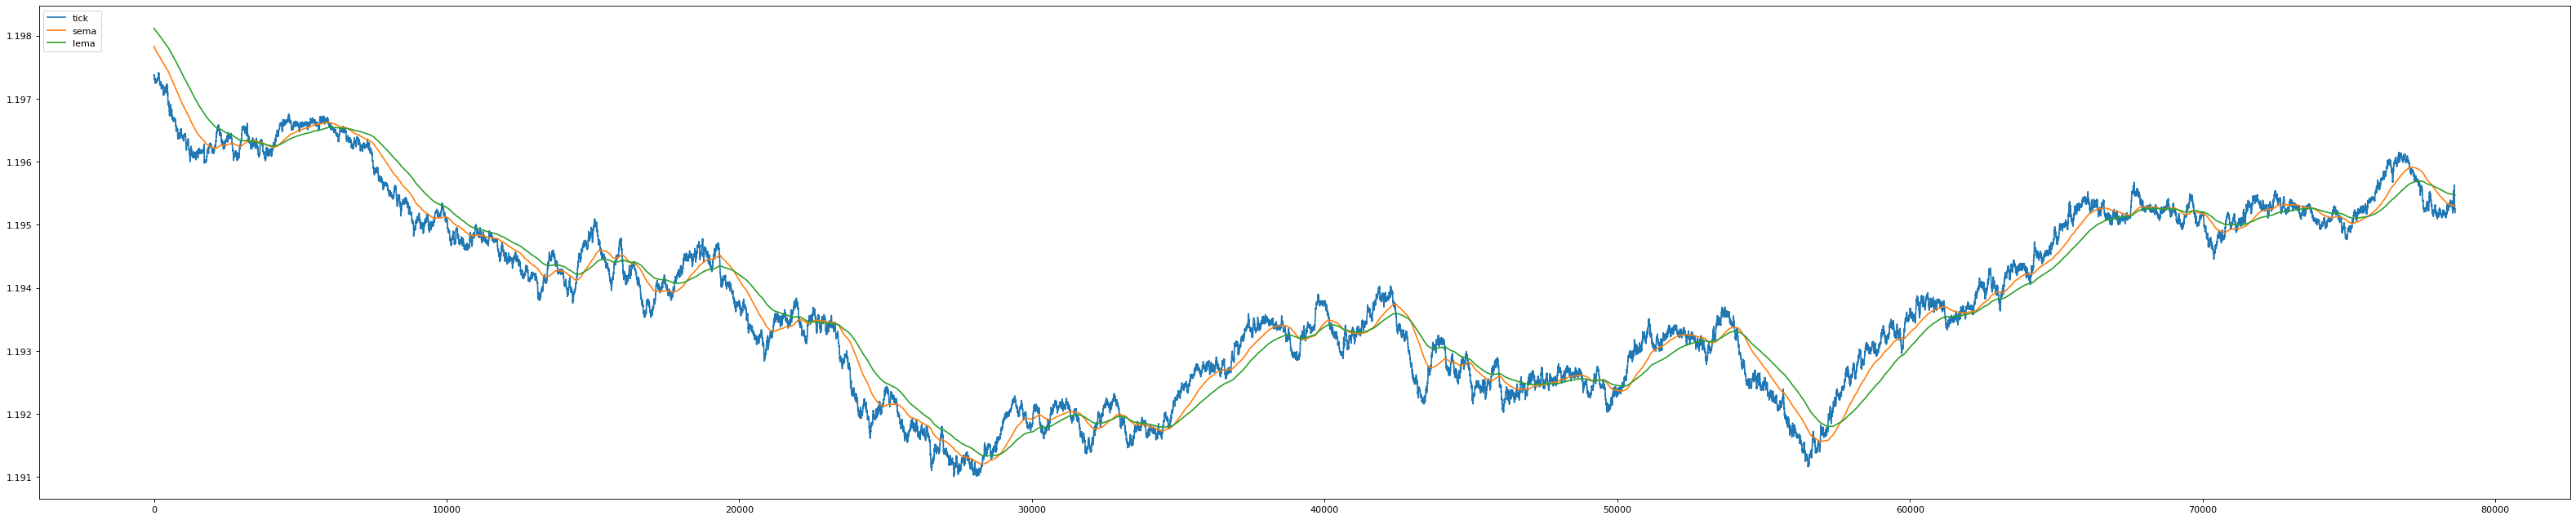

In [18]:
data = get_date_list(data)
read_data(data)
#data["df"] = data["df"][0:100]
print(f'Record num : {len(data["df"])}')    
data["df"] = data["df"].reset_index(drop = True)

data['open_order'] = False    
data = run_engine(data)

plot_graph(data)
print_report(data)
data['total_df'] = pd.DataFrame({'date':data['dt_list'], 'pls': data['pl_list']})
split_date_col(data)
data['total_df'] = data['total_df'][['date', 'year_val', 'month_val', 'date_val', 'hour_val','minute_val', 'pls']]
data["total_df"] = data["total_df"].reset_index(drop = True)    
data['file_name'] = f'data\{data["start_date"].year}-{data["start_date"].month}-({data["start_date"].day}-{data["end_date"].day}).csv'

data['total_df'].to_csv(data['file_name'], index = False) 

In [19]:
print(data['total_df'].groupby(['date_val'])['pls'].sum())

date_val
12    0.0013
Name: pls, dtype: float64


In [20]:
data['total_df']['pls'].value_counts()

-0.0002    8
-0.0001    6
-0.0003    5
-0.0004    4
 0.0010    2
 0.0002    2
-0.0000    2
 0.0012    1
 0.0011    1
 0.0004    1
 0.0001    1
 0.0014    1
Name: pls, dtype: int64

In [21]:
data['total_df']

,date,year_val,month_val,date_val,hour_val,minute_val,pls
0,2021-03-12 03:33:07,2021,3,12,3,33,-0.0000
1,2021-03-12 04:02:07,2021,3,12,4,2,-0.0002
2,2021-03-12 05:13:47,2021,3,12,5,13,0.0000
3,2021-03-12 06:39:38,2021,3,12,6,39,0.0010
4,2021-03-12 07:53:09,2021,3,12,7,53,-0.0003
5,2021-03-12 08:02:56,2021,3,12,8,2,-0.0002
6,2021-03-12 08:24:30,2021,3,12,8,24,-0.0002
7,2021-03-12 08:50:57,2021,3,12,8,50,0.0002
8,2021-03-12 09:04:27,2021,3,12,9,4,-0.0001
9,2021-03-12 09:59:50,2021,3,12,9,59,0.0014


In [22]:
winsound.PlaySound('C:\\Windows\\Media\\chimes.wav', winsound.SND_ASYNC)